In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["MAX_PIXELS"] = '256*28*28'

In [2]:
from PIL import Image, ImageDraw
from qwen import Qwen2VLForAttnExtraction, bbox_from_att_image_adaptive

small_model = Qwen2VLForAttnExtraction()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
from qwen_vl_utils import smart_resize

image = Image.open("/data1/cache/huggingface/hub/datasets--deepcs233--Visual-CoT/snapshots/041786024efbac07ab71767ee080c4cbbfb82400/cot_image_data/docvqa/ffbg0227_2.png")

h, w = image.size

input_height,input_width = smart_resize(h, w, min_pixels=256*28*28, max_pixels=256*28*28)

image = image.resize((input_height, input_width))

In [24]:
attn = small_model.extract_attention(
    "Who's the sender?",
    image,
    # [],
    attn_type="contrastive",
    single_token_generation=True,
    contrast_layers=(15, 6),
)


In [25]:
attn[0].shape


torch.Size([19, 15])

In [26]:
bbox = bbox_from_att_image_adaptive(attn[0], image.size, bbox_size=14 * 14)
bbox


(0, 0, 196, 196)

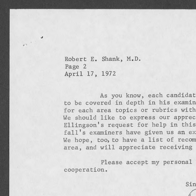

In [27]:

crop_image = image.crop(bbox)
crop_image


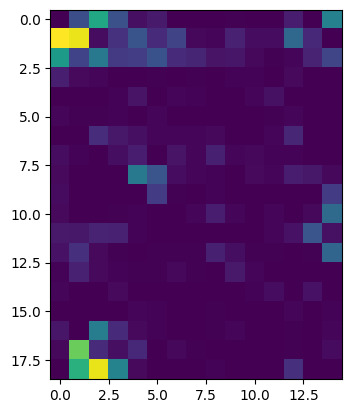

In [28]:
import matplotlib.pyplot as plt

plt.imshow(attn[0])

In [13]:
import torch
import torch.nn.functional as F
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

model = Qwen2VLForConditionalGeneration.from_pretrained(
 "Qwen/Qwen2-VL-7B-Instruct",
 torch_dtype=torch.bfloat16,
 attn_implementation="eager",
 device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
model.embed_weight = None


In [15]:
original_forward = model.forward


In [16]:
from typing import List, Optional, Tuple, Union
from transformers.models.qwen2_vl.modeling_qwen2_vl import Qwen2VLCausalLMOutputWithPast

def patch_forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        pixel_values: Optional[torch.Tensor] = None,
        pixel_values_videos: Optional[torch.FloatTensor] = None,
        image_grid_thw: Optional[torch.LongTensor] = None,
        video_grid_thw: Optional[torch.LongTensor] = None,
        rope_deltas: Optional[torch.LongTensor] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple, Qwen2VLCausalLMOutputWithPast]:
        r"""
        Args:
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        Example:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, Qwen2VLForConditionalGeneration

        >>> model = Qwen2VLForConditionalGeneration.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
        >>> processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

        >>> messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "What is shown in this image?"},
                ],
            },
        ]
        >>> url = "https://www.ilankelman.org/stopsigns/australia.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        >>> inputs = processor(text=[text], images=[image], vision_infos=[vision_infos])

        >>> # Generate
        >>> generate_ids = model.generate(inputs.input_ids, max_length=30)
        >>> tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        "The image shows a street scene with a red stop sign in the foreground. In the background, there is a large red gate with Chinese characters ..."
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if inputs_embeds is None:
            inputs_embeds = self.model.embed_tokens(input_ids)
            if pixel_values is not None:
                pixel_values = pixel_values.type(self.visual.get_dtype())
                image_embeds = self.visual(pixel_values, grid_thw=image_grid_thw)
                n_image_tokens = (input_ids == self.config.image_token_id).sum().item()
                n_image_features = image_embeds.shape[0]
                if n_image_tokens != n_image_features:
                    raise ValueError(
                        f"Image features and image tokens do not match: tokens: {n_image_tokens}, features {n_image_features}"
                    )
                image_mask = (
                    (input_ids == self.config.image_token_id)
                    .unsqueeze(-1)
                    .expand_as(inputs_embeds)
                    .to(inputs_embeds.device)
                )
                image_embeds = image_embeds.to(inputs_embeds.device, inputs_embeds.dtype)
                #print(image_embeds.shape)
                if self.embed_weight is not None:
                    #print(image_embeds.shape)
                    #print(self.embed_weight.shape)
                    #print(image_embeds)
                    #print(self.embed_weight)
                    image_embeds[:self.embed_weight.shape[0], :] *= self.embed_weight[:, None]
                inputs_embeds = inputs_embeds.masked_scatter(image_mask, image_embeds)

            if pixel_values_videos is not None:
                pixel_values_videos = pixel_values_videos.type(self.visual.get_dtype())
                video_embeds = self.visual(pixel_values_videos, grid_thw=video_grid_thw)
                n_video_tokens = (input_ids == self.config.video_token_id).sum().item()
                n_video_features = video_embeds.shape[0]
                if n_video_tokens != n_video_features:
                    raise ValueError(
                        f"Video features and video tokens do not match: tokens: {n_video_tokens}, features {n_video_features}"
                    )
                video_mask = (
                    (input_ids == self.config.video_token_id)
                    .unsqueeze(-1)
                    .expand_as(inputs_embeds)
                    .to(inputs_embeds.device)
                )
                video_embeds = video_embeds.to(inputs_embeds.device, inputs_embeds.dtype)
                inputs_embeds = inputs_embeds.masked_scatter(video_mask, video_embeds)

            if attention_mask is not None:
                attention_mask = attention_mask.to(inputs_embeds.device)

        # if we get 4D attention mask we cannot calculate rope deltas anymore. TODO @raushan fixme
        if position_ids is None and (attention_mask is None or attention_mask.ndim == 2):
            # calculate RoPE index once per generation in the pre-fill stage only
            if (
                (cache_position is not None and cache_position[0] == 0)
                or self.rope_deltas is None
                or (past_key_values is None or past_key_values.get_seq_length() == 0)
            ):
                position_ids, rope_deltas = self.get_rope_index(
                    input_ids, image_grid_thw, video_grid_thw, attention_mask
                )
                self.rope_deltas = rope_deltas
            # then use the prev pre-calculated rope-deltas to get the correct position ids
            else:
                batch_size, seq_length, _ = inputs_embeds.shape
                delta = cache_position[0] + self.rope_deltas if cache_position is not None else 0
                position_ids = torch.arange(seq_length, device=inputs_embeds.device)
                position_ids = position_ids.view(1, -1).expand(batch_size, -1)
                if cache_position is not None:  # otherwise `deltas` is an int `0`
                    delta = delta.repeat_interleave(batch_size // delta.shape[0], dim=0)
                    delta = delta.to(position_ids.device)
                position_ids = position_ids.add(delta)
                position_ids = position_ids.unsqueeze(0).expand(3, -1, -1)

        outputs = self.model(
            input_ids=None,
            position_ids=position_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            cache_position=cache_position,
        )

        hidden_states = outputs[0]
        logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Upcast to float if we need to compute the loss to avoid potential precision issues
            logits = logits.float()
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return Qwen2VLCausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            rope_deltas=self.rope_deltas,
        )

model.forward = patch_forward.__get__(model, Qwen2VLForConditionalGeneration)


In [28]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Where are the wheels?"},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
# image_inputs, video_inputs = process_vision_info(messages)
# print(image_inputs)


In [29]:
inputs = processor(
    text=[text],
    images=[image, crop_image],
    # videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
# output_ids = model.generate(
#             **inputs,
#             return_dict_in_generate=True,
#             output_attentions=True,
#             max_new_tokens=128,
#         )


In [30]:
from typing import Literal

# Apply weighted attention to vision tokens, fix multiple images
def reweighted_vision_tokens(
    vision_attn_weight,
    keep_percentage,
    weighting_type: Literal["linear", "uniform", "suppress"] = "linear",
    lowest_weight=0.6,
    neg_attn_weight=None,
    suppress_alpha=0.5,
):
    if weighting_type == "suppress":
        if neg_attn_weight is None:
            raise ValueError("neg_attn_weight must be provided for suppress mode")
        # 使用负样例注意力权重进行抑制
        weight_vision_token = 1 - suppress_alpha * neg_attn_weight
        return weight_vision_token

    sorted_indices = torch.argsort(vision_attn_weight, descending=True)
    num_tokens_to_keep = int(len(vision_attn_weight) * keep_percentage)
    weight_vision_token = torch.zeros_like(vision_attn_weight, dtype=torch.float)
    weight_vision_token[sorted_indices[:num_tokens_to_keep]] = 1.0
    if weighting_type == "linear":
        weight_vision_token[sorted_indices[num_tokens_to_keep:]] = torch.linspace(
            lowest_weight, 1.0, len(vision_attn_weight) - num_tokens_to_keep
        )
    else:
        weight_vision_token[sorted_indices[num_tokens_to_keep:]] = lowest_weight
    return weight_vision_token


In [31]:
attn_flat = attn[0].flatten()

weight = reweighted_vision_tokens(attn_flat, keep_percentage=0.3, weighting_type="linear")

model.embed_weight = weight.to(model.device)


In [32]:
model.embed_weight.shape


torch.Size([391])

In [33]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
]
out = processor.tokenizer.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
response = out[0]
print(response)


The are two wheels visible in the image. One wheel is located on the left side of the skateboard, and the other wheel is on the right side of the skateboard.
